#### Assignment 4: Cost sensitive Logistic Regression
#### Submitted by:
#### 1)Parth Nitesh Thakkar(CS22MTECH14005)
#### 2)Rithik Agarwal(CS22MTECH11004)
#### 3)Vinayak Nambiar(AI22MTECH13005)
#### 4)Roshin Roy(AI22MTECH13006)
#### 5)SarveshKumar Purohit(AI22MTECH14006)

#### In this Assignment i have tried 3 approaches
#### 1)Genetic algorithm based Logistic regression with cost sensitive loss
#### 2)Logistic regression with cost sensitive loss and Adam optimizer
#### 3)Vanilla Logistic regression with Adam optimizer and BCE(Binary cross entropy) loss

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import math
import torch
import torch.nn as nn
from tabulate import tabulate
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

## Reading the dataset

In [ ]:
df = pd.read_csv('costsensitiveregression.csv')

In [ ]:
df.head()

,NotCount,YesCount,ATPM,PFD,PFG,SFD,SFG,WP,WS,AH,AN,Status,FNC
0,2,21,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0
1,23,0,0.0,0.044,0.0,0.0,0.0,0.306179,0.0,0.0,0.0,1,0.0
2,1,22,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0
3,5,18,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1,0.0
4,1,22,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147636 entries, 0 to 147635
Data columns (total 13 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   NotCount  147636 non-null  int64  
 1   YesCount  147636 non-null  int64  
 2   ATPM      147636 non-null  float64
 3   PFD       147636 non-null  float64
 4   PFG       147636 non-null  float64
 5   SFD       147636 non-null  float64
 6   SFG       147636 non-null  float64
 7   WP        147636 non-null  float64
 8   WS        147636 non-null  float64
 9   AH        147636 non-null  float64
 10  AN        147636 non-null  float64
 11  Status    147636 non-null  int64  
 12  FNC       147636 non-null  float64
dtypes: float64(10), int64(3)
memory usage: 14.6 MB


In [ ]:
#Counting the number of data rows having status bit 1 and 0
ones = 0
zeros = 0
for i in df.loc[:,'Status']:
    if i == 1:
      ones += 1
    else:
      zeros += 1  
print("No of rows with status 1 are ",ones)
print("No of rows with status 0 are ",zeros)

No of rows with status 1 are  44082
No of rows with status 0 are  103554


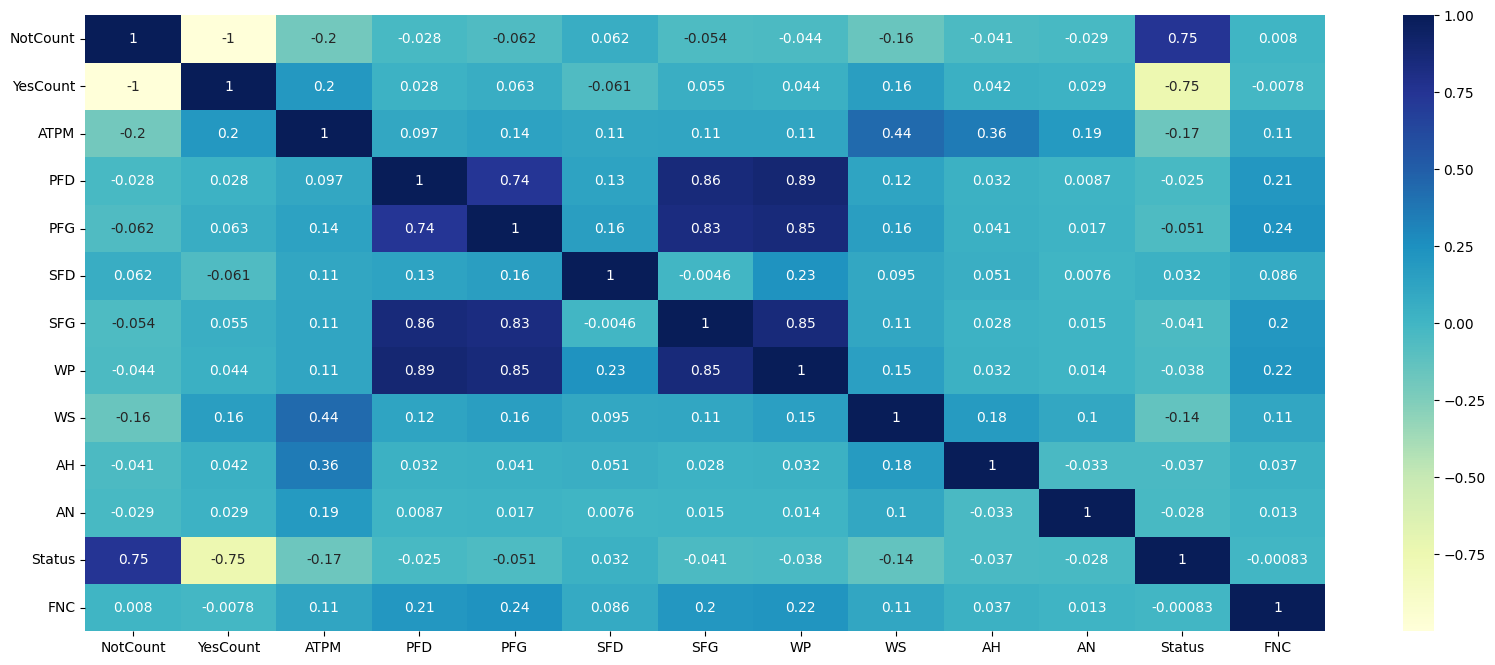

In [ ]:
# plotting correlation heatmap
fig, ax = plt.subplots(figsize=(20,8))         # Sample figsize in inches
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)

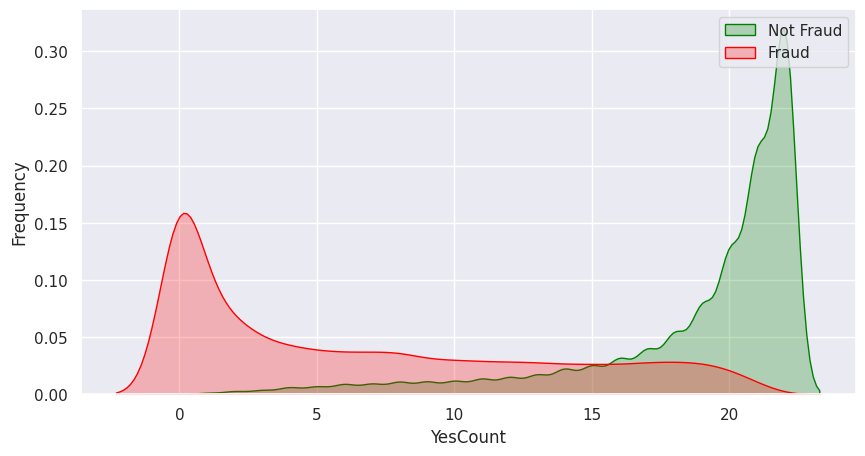

In [ ]:
#Observation : there is a high co-relation of yes count and no count with status
# Set the figure size
sns.set(rc={"figure.figsize": (10, 5)})

# Filter the dataset by non-null "YesCount" values and "Status" variable
non_fraud = df.loc[(df["Status"] == 0) & (df["YesCount"].notnull()), "YesCount"]
fraud = df.loc[(df["Status"] == 1) & (df["YesCount"].notnull()), "YesCount"]

# Create a KDE plot for non-fraud cases in green
g = sns.kdeplot(non_fraud, color="green", shade=True)

# Overlay a KDE plot for fraud cases in red on the previous plot
g = sns.kdeplot(fraud, ax=g, color="red", shade=True)

# Set the labels for the x and y axes
g.set_xlabel("YesCount")
g.set_ylabel("Frequency")

# Add a legend to identify non-fraud and fraud cases
g = g.legend(["Not Fraud", "Fraud"])

In [ ]:
#Here X contains all 11 features
X = df.iloc[:,:-2].values

#Here y contains the true label and their respective False negative costs
y = df.iloc[:,-2:].values

## Train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , random_state=42)

## Performing Standard scalling

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Logistic Regression Model

In [ ]:
class LR(nn.Module):
    def __init__(self, input_dim,output_dim):
        super(LR, self).__init__()
        self.l1 = nn.Linear(input_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        out = self.l1(x)
        out = self.sig(out)

        return out

## Cost Sensitive Loss function
$$
\begin{aligned}
     L(\theta) = 1/N \sum_i^N (y_i(h_\theta(X_i)C_{tp_i} &+ (1-h_\theta(X_i))C_{fp_i})+\\
     (1-y_i)(h_\theta(x_i))C_{fp_i} &+ (1-h_\theta(x_i))C_{tn_i})
\end{aligned}
$$

In [ ]:
def cost_loss(y,y_pred,c_tp,c_fn,c_fp,c_tn):
  cost = 0
  for i in range(len(y)):
    cost += (y[i]*(y_pred[i]*c_tp + (1-y_pred[i])*c_fn[i]) + (1-y[i])*(y_pred[i]*c_fp+(1-y_pred[i])*c_tn))
  return cost/len(y)

## Training LR Model using Genetic Algorithm with Cost sensitive Loss 

In [ ]:
!pip install pygad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#defining sigmoid function
def sigmoid(x):
  return 1/(1+np.exp(-x))

In [ ]:
#library used for implementing genetic algorithm
import pygad

In [ ]:
#fitness function for the genetic algorithm
def fitness(ga_instance,sol,sol_idx):
  global X_train, y_train, torch_ga, model, cost_loss
  y_pred = sigmoid(np.matmul(X_train,sol))
  solution_fitness = 1.0 / (cost_loss(y = y_train[:,0],y_pred = y_pred,c_tp = 4,c_fn = y_train[:,1],c_fp = 4,c_tn = 0) + 0.00000001)

  return solution_fitness

In [ ]:
#defining all the parameters for the genetic algorithm
fitness_function = fitness

num_generations = 30
num_parents_mating = 5

sol_per_pop = 30
num_genes = 11

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10

In [ ]:
#function that will print our progress
def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))

In [ ]:
#Creating the instance of a pygad class with all the parameters defined above
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       on_generation=callback_generation)

In [ ]:
ga_instance.run()

Generation = 1
Fitness    = 0.09844631752340624
Generation = 2
Fitness    = 0.24382652973387317
Generation = 3
Fitness    = 0.2523794200301439
Generation = 4
Fitness    = 0.26776085247196724
Generation = 5
Fitness    = 0.27699944625353295
Generation = 6
Fitness    = 0.2945225928305573
Generation = 7
Fitness    = 0.30015889016801767
Generation = 8
Fitness    = 0.30480860488312034
Generation = 9
Fitness    = 0.3096162482119354
Generation = 10
Fitness    = 0.31433154526364043
Generation = 11
Fitness    = 0.31706962020380636
Generation = 12
Fitness    = 0.3190252005090176
Generation = 13
Fitness    = 0.32457279862854255
Generation = 14
Fitness    = 0.3255025544941468
Generation = 15
Fitness    = 0.3255492691478999
Generation = 16
Fitness    = 0.32784230149636046
Generation = 17
Fitness    = 0.3296377534239755
Generation = 18
Fitness    = 0.3310430864532424
Generation = 19
Fitness    = 0.3326018516489394
Generation = 20
Fitness    = 0.3339222688369249
Generation = 21
Fitness    = 0.33506562

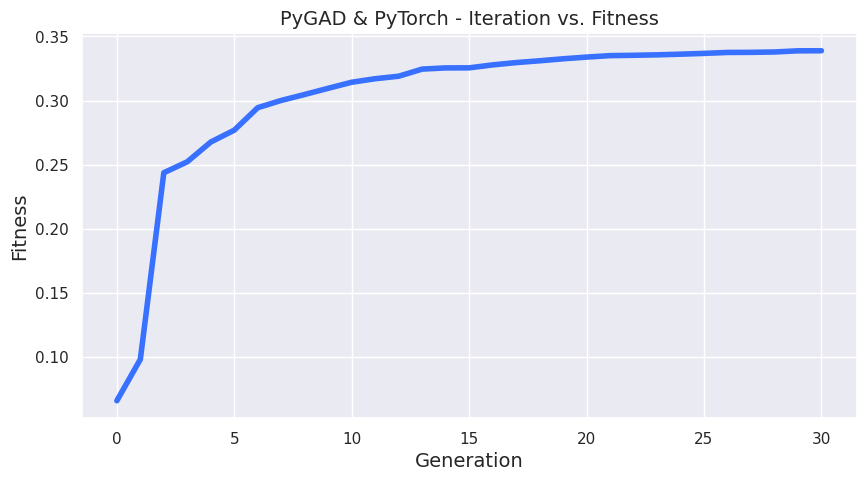

In [ ]:
# After the generations complete, some plots are showed that summarize how the outputs/fitness values evolve over generations.
ga_instance.plot_fitness(title="PyGAD & PyTorch - Iteration vs. Fitness", linewidth=4)
plt.show()

In [ ]:
#Printing the parameters of the best solution and its fitness
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Parameters of the best solution : [ 6.66242895 -3.76946611  8.47342699 -0.46351315 -0.70117369  2.23383629
  0.65668211  0.2382242   1.77021864  0.49206384 -0.09468903]
Fitness value of the best solution = 0.3388687105395389


In [ ]:
#Predicting using the solution given by GA
y_pred = sigmoid(np.matmul(X_test,solution))

In [ ]:
#Classifing by keeping threshold as 0.5
for i in range(len(y_pred)):
  if y_pred[i] >= 0.5:
    y_pred[i] = 1
  else:
    y_pred[i] = 0

### Evaluating LR Model that was trained using Genetic Algorithm with Cost sensitive Loss 

In [ ]:
#Eveluating our model in terms of cost
GA_CSLR = cost_loss(y = y_test[:,0],y_pred = y_pred,c_tp = 4,c_fn = y_test[:,1],c_fp = 4,c_tn = 0)
print(f"Avg Cost for LR model that was trained using Genetic Algorithm with Cost sensitive Loss  : {round(GA_CSLR,2)}")

Avg Cost for LR model that was trained using Genetic Algorithm with Cost sensitive Loss  : 2.8


## Converting data to tensors

In [ ]:
X_train = torch.tensor(X_train,dtype = torch.float32)
X_test = torch.tensor(X_test,dtype = torch.float32)
y_train = torch.tensor(y_train,dtype = torch.float32)
y_test = torch.tensor(y_test,dtype = torch.float32)

## Training LR Model using Cost sensitive Loss with Adam optimizer

In [ ]:
#Initializing The LR model
torch.manual_seed(8)
Lr = LR(11,1)

In [ ]:
#Defining the optimizer(Adam in this case)
optimizer = torch.optim.Adam(Lr.parameters(),lr=0.01)

#Array to record the avg loss at epochs
losses_cost = []

In [ ]:
epochs = 100
for ep in range(epochs):
      #performing the forward pass
      y_pred = Lr(X_train)

      #Calculating the loss by using the cost sensitive loss function that we defined earlier
      l = cost_loss(y = y_train[:,0],y_pred = y_pred,c_tp = 4,c_fn = y_train[:,1],c_fp = 4,c_tn = 0)

      #Recording the Avg loss of current epoch 
      losses_cost.append(l.detach())

      #Performing the backward pass and updating the parameters
      optimizer.zero_grad()
      l.backward()
      optimizer.step()

      #Printing the loss
      if (ep+1) % 2 == 0 or ep == 0:
        print(f"Avg Loss at epoch {ep+1} :",l.detach().item())

Avg Loss at epoch 1 : 71.48103332519531
Avg Loss at epoch 2 : 67.40886688232422
Avg Loss at epoch 4 : 59.51860427856445
Avg Loss at epoch 6 : 52.80095672607422
Avg Loss at epoch 8 : 47.06163787841797
Avg Loss at epoch 10 : 42.06599044799805
Avg Loss at epoch 12 : 37.72386169433594
Avg Loss at epoch 14 : 33.96712112426758
Avg Loss at epoch 16 : 30.738637924194336
Avg Loss at epoch 18 : 27.969112396240234
Avg Loss at epoch 20 : 25.59047508239746
Avg Loss at epoch 22 : 23.549541473388672
Avg Loss at epoch 24 : 21.801109313964844
Avg Loss at epoch 26 : 20.297996520996094
Avg Loss at epoch 28 : 18.998809814453125
Avg Loss at epoch 30 : 17.875051498413086
Avg Loss at epoch 32 : 16.892688751220703
Avg Loss at epoch 34 : 16.035003662109375
Avg Loss at epoch 36 : 15.278061866760254
Avg Loss at epoch 38 : 14.606678009033203
Avg Loss at epoch 40 : 14.008472442626953
Avg Loss at epoch 42 : 13.475210189819336
Avg Loss at epoch 44 : 12.993313789367676
Avg Loss at epoch 46 : 12.557520866394043
Avg Lo

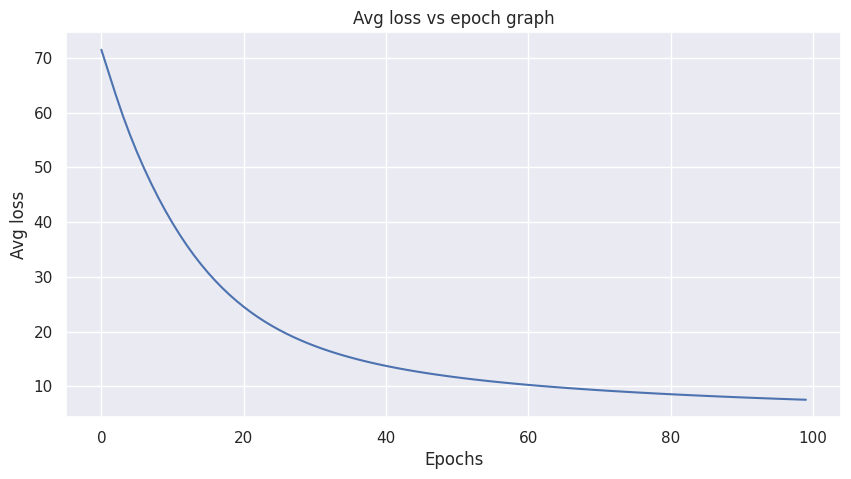

In [ ]:
#Plotting the loss vs epoch graph
plt.xlabel("Epochs")
plt.ylabel("Avg loss")
plt.title("Avg loss vs epoch graph")
plt.plot(np.arange(0,len(losses_cost)),losses_cost)
plt.show()

### Evaluating LR model that was trained using Adam optimizer and Cost sensitive loss

In [ ]:
y_temp = Lr(X_test)
y_pred = []

In [ ]:
#Classifing by keeping threshold as 0.5
for i in range(len(y_temp)):
   if(y_temp[i]>= 0.5):
     y_pred.append(1)
   else:
     y_pred.append(0)

In [ ]:
#Eveluating our model in terms of cost
CSLR = cost_loss(y = y_test[:,0],y_pred = y_pred,c_tp = 4,c_fn = y_test[:,1],c_fp = 4,c_tn = 0)
print(f"Avg Cost for LR model that was trained using Adam optimizer and Cost sensitive loss : {round(CSLR.detach().item(),2)}")

Avg Cost for LR model that was trained using Adam optimizer and Cost sensitive loss : 2.67


## Vanilla LR with Adam optimizer and BCE loss

In [ ]:
torch.manual_seed(8)

#Initializing the model
model1 = LR(11,1)

#Declaring the optimizer(Adam in this case)
optimizer1 = torch.optim.Adam(model1.parameters(),lr=0.03)

In [ ]:
#Loss function in binary cross entropy
criterion = nn.BCELoss()

#Array value to record loss values
losses = []

In [ ]:
epochs = 100
for ep in range(epochs):
  #Forward pass of the LR model
  y_pred = model1(X_train)

  #Calculating the loss
  l = criterion(y_pred.squeeze(1),y_train[:,0])

  #Recording the avg loss of the current epoch
  losses.append(l.detach())

  #Performing the backward pass and updating parameters
  optimizer1.zero_grad()
  l.backward()
  optimizer1.step()

  #Printing the loss of the epochs
  if (ep+1) % 2 == 0 or ep == 0:
    print(f"Avg Loss at epoch {ep+1} :",l.detach().item())

Avg Loss at epoch 1 : 0.8137882947921753
Avg Loss at epoch 2 : 0.7737124562263489
Avg Loss at epoch 4 : 0.7027652263641357
Avg Loss at epoch 6 : 0.6413971185684204
Avg Loss at epoch 8 : 0.5898303389549255
Avg Loss at epoch 10 : 0.5471150875091553
Avg Loss at epoch 12 : 0.5117497444152832
Avg Loss at epoch 14 : 0.48206833004951477
Avg Loss at epoch 16 : 0.45670923590660095
Avg Loss at epoch 18 : 0.4347888231277466
Avg Loss at epoch 20 : 0.41576480865478516
Avg Loss at epoch 22 : 0.3993943929672241
Avg Loss at epoch 24 : 0.38581642508506775
Avg Loss at epoch 26 : 0.3734091818332672
Avg Loss at epoch 28 : 0.36275094747543335
Avg Loss at epoch 30 : 0.35224446654319763
Avg Loss at epoch 32 : 0.3447651267051697
Avg Loss at epoch 34 : 0.3387409448623657
Avg Loss at epoch 36 : 0.33365973830223083
Avg Loss at epoch 38 : 0.32936978340148926
Avg Loss at epoch 40 : 0.3258371353149414
Avg Loss at epoch 42 : 0.3229962885379791
Avg Loss at epoch 44 : 0.3206838369369507
Avg Loss at epoch 46 : 0.318697

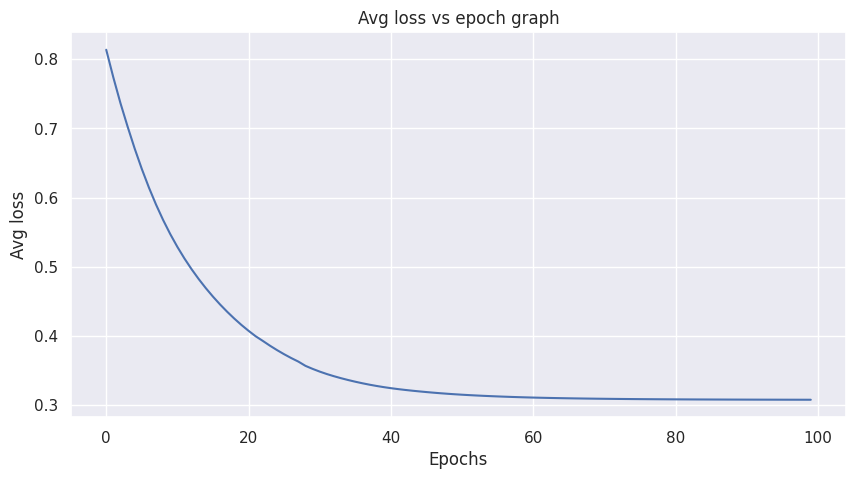

In [ ]:
#Plotting the loss vs epoch graph
plt.xlabel("Epochs")
plt.ylabel("Avg loss")
plt.title("Avg loss vs epoch graph")
plt.plot(np.arange(0,len(losses)),losses)
plt.show()

### Evaluating Vanilla LR model that was trained using Adam optimizer and BCE loss

In [ ]:
y_pred = model1(X_test)

In [ ]:
#Classifing by keeping threshold as 0.5
for i in range(len(y_pred)):
  if y_pred[i] >= 0.5:
    y_pred[i] = 1
  else:
    y_pred[i] = 0

In [ ]:
#Printing the avg cost of vanilla logistic regression model
C_LR = cost_loss(y = y_test[:,0],y_pred = y_pred,c_tp = 4,c_fn = y_test[:,1],c_fp = 4,c_tn = 0)
print(f"Avg Cost for Vanilla Logistic Regression : {round(C_LR.detach().item(),2)}")

Avg Cost for Vanilla Logistic Regression : 26.54


## Final costs of various methods

In [ ]:
# assign data
methods_and_costs = [
    ["Vanilla LR with Adam optimizer and BCE loss", C_LR*len(y_test),C_LR],
    ["LR with Cost sensitive loss and Adam optimizer", CSLR*len(y_test),CSLR],
    ["LR with cost sensitive loss and trained using genetic algorithm", GA_CSLR*len(y_test),GA_CSLR],
]
 
# create header
head = ["Method","Total cost(Lower is better)","Avg Cost(Lower is better)"]
 
# display table
print(tabulate(methods_and_costs, headers=head, tablefmt='orgtbl'))
print()
print("We can observe that LR trained using Genetic algorithm performs the best")

| Method                                                          |   Total cost(Lower is better) |   Avg Cost(Lower is better) |
|-----------------------------------------------------------------+-------------------------------+-----------------------------|
| Vanilla LR with Adam optimizer and BCE loss                     |                      783682   |                    26.5403  |
| LR with Cost sensitive loss and Adam optimizer                  |                       78975.9 |                     2.67461 |
| LR with cost sensitive loss and trained using genetic algorithm |                       82729.9 |                     2.80174 |

We can observe that LR trained using Genetic algorithm performs the best


## Savings Score

$$
\text{cost of vanilla logistic regression = CLR}\\
\text{cost of cost sensitive logistic regression = CSLR}\\
\textit{Savings cost = }\dfrac{CLR - CSLR}{CLR}
$$

In [ ]:
print(f"Savings Score of LR vs Cost sensitive Genetic Algorithm based LR is {round((((C_LR-GA_CSLR))/C_LR).detach().item(),4)}")
print(f"Savings Score of LR vs Cost sensitive LR with adam optimizer is     {round((((C_LR-CSLR))/C_LR).detach().item(),4)}")

Savings Score of LR vs Cost sensitive Genetic Algorithm based LR is 0.8944
Savings Score of LR vs Cost sensitive LR with adam optimizer is     0.8992
